In [1]:
import kagglehub

# Download dataset
path_dataset = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print('Data source import complete.')

100%|██████████| 2.29G/2.29G [00:25<00:00, 97.1MB/s]

Extracting files...


Data source import complete.


In [2]:
import os, shutil
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
train_path = os.path.join(path_dataset, "chest_xray", "train")

for dirpath, dirnames, filenames in os.walk(train_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train'.
There are 0 directories and 1341 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL'.
There are 0 directories and 3875 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA'.


In [4]:
test_path = os.path.join(path_dataset, "chest_xray", "test")

for dirpath, dirnames, filenames in os.walk(test_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test'.
There are 0 directories and 234 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/NORMAL'.
There are 0 directories and 390 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA'.


In [5]:
val_path = os.path.join(path_dataset, "chest_xray", "val")

for dirpath, dirnames, filenames in os.walk(val_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val'.
There are 0 directories and 8 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/NORMAL'.
There are 0 directories and 8 images in '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/PNEUMONIA'.




### display some images from the dataset

In [ ]:
def view_image_before_after_resizing(data_dir, labels, class_names, img_size):
    # Choose a random class
    random_class = random.choice(labels)
    class_index = labels.index(random_class)

    folder_path = os.path.join(data_dir, random_class)

    # Choose a random image from the folder
    random_image_name = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, random_image_name)

    # Load the image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image
    resized_image = cv2.resize(original_image, (img_size, img_size))

    plt.figure(figsize=(12, 6))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Image\nClass: {random_class}")
    plt.axis("off")
    print(f"Original Image Shape: {original_image.shape}")

    # Plot the resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_image, cmap='gray')
    plt.title(f"Resized Image\n({img_size}x{img_size})")
    plt.axis("off")
    print(f"Resized Image Shape: {resized_image.shape}")

    plt.tight_layout()
    plt.show()

Original Image Shape: (1059, 1442)
Resized Image Shape: (512, 512)


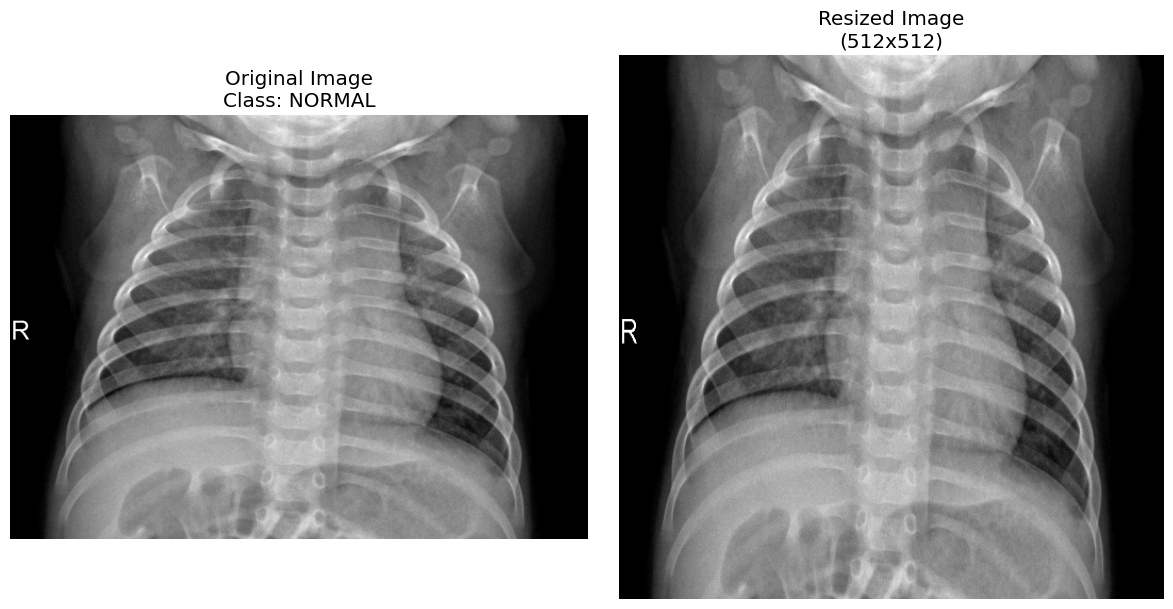

In [ ]:
view_image_before_after_resizing(train_path, labels, labels, 512)

In [ ]:
def calculate_average_shape(data_dir, labels):
    total_height, total_width, count = 0, 0, 0

    for label in labels:
        class_path = os.path.join(data_dir, label)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                height, width = img.shape[:2]
                total_height += height
                total_width += width
                count += 1

    # Compute average height and width
    avg_height = total_height // count
    avg_width = total_width // count

    return avg_height, avg_width

# Calculate average shape
average_shape = calculate_average_shape(train_path, labels)
print(f"Average Image Shape: {average_shape[0]}x{average_shape[1]}")


Average Image Shape: 968x1320


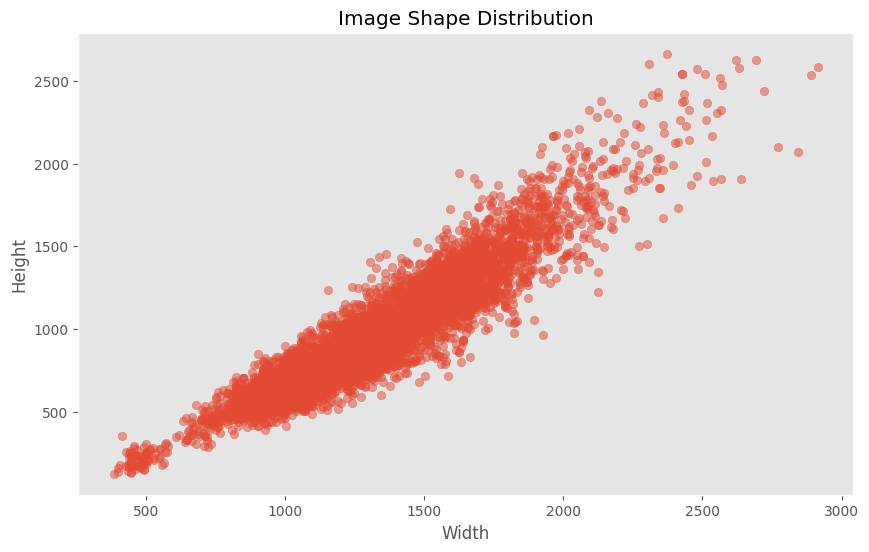

In [ ]:
import matplotlib.pyplot as plt

def plot_image_shapes(data_dir, labels):
    widths, heights = [], []
    for label in labels:
        class_path = os.path.join(data_dir, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                height, width = img.shape[:2]
                widths.append(width)
                heights.append(height)

    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.5)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image Shape Distribution")
    plt.grid()
    plt.show()

plot_image_shapes(train_path, labels)


## Model building

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

In [7]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

IMG_SIZE = (224, 224)

# Import data from directories and turn them into batches
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_path,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="binary",
                                                                            batch_size=32,
                                                                 shuffle=True,
                                                                 seed=42)
train_data = train_data.map(lambda x, y: (x/255.0, y))

valid_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_path,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="binary",
                                                                            batch_size=32,
                                                                 shuffle=False)
valid_data = valid_data.map(lambda x, y: (x/255.0, y))

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_path,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="binary",
                                                                            batch_size=32,
                                                                shuffle=False)
test_data = test_data.map(lambda x, y: (x/255.0, y))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
for image, label in valid_data.take(1):  # Take the first sample
    print("Image size:", image)  # If it's a tf.Tensor
    print("Label:", label.numpy())
    print("Label size:", label.shape)

Image size: tf.Tensor(
[[[[1.94530323e-01 1.94530323e-01 1.94530323e-01]
   [1.04541634e-03 1.04541634e-03 1.04541634e-03]
   [5.06327376e-02 5.06327376e-02 5.06327376e-02]
   ...
   [3.04840803e-01 3.04840803e-01 3.04840803e-01]
   [2.85826147e-01 2.85826147e-01 2.85826147e-01]
   [2.57376939e-01 2.57376939e-01 2.57376939e-01]]

  [[1.92826777e-03 1.92826777e-03 1.92826777e-03]
   [8.44587479e-03 8.44587479e-03 8.44587479e-03]
   [5.31262532e-02 5.31262532e-02 5.31262532e-02]
   ...
   [3.14982682e-01 3.14982682e-01 3.14982682e-01]
   [2.84636945e-01 2.84636945e-01 2.84636945e-01]
   [2.36450419e-01 2.36450419e-01 2.36450419e-01]]

  [[3.29454094e-01 3.29454094e-01 3.29454094e-01]
   [5.80782115e-01 5.80782115e-01 5.80782115e-01]
   [4.10689265e-02 4.10689265e-02 4.10689265e-02]
   ...
   [3.02034110e-01 3.02034110e-01 3.02034110e-01]
   [2.75582969e-01 2.75582969e-01 2.75582969e-01]
   [2.33260468e-01 2.33260468e-01 2.33260468e-01]]

  ...

  [[0.00000000e+00 0.00000000e+00 0.0000000

## callbacks

In [8]:
import tensorflow as tf

In [9]:
# function to use Tensorboard callback to track model's performances
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Helper functions - plot_loss_curves

In [11]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    accuracy = history.history['accuracy']
    val_accuracy = history.history.get('val_accuracy', [])

    epochs = range(len(loss))
    val_epochs = range(len(val_loss))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    if val_loss:
        plt.plot(val_epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    if val_accuracy:
        plt.plot(val_epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

## Optimize the custom model built by myself


### Try developing a custom CNN model using Sequential API.
### No. of features will be reduced.

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# a model with some convo and pooling layers that are less complex than EfficientNetV2B0
custom_model = Sequential([
  Conv2D(10, 1, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 1, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 1, activation='relu'),
  Conv2D(10, 1, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])
# Compile the model
custom_model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy", keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
custom_model_history = custom_model.fit(train_data,
                                 epochs=25,
                                 validation_data=valid_data,
                                 callbacks=[callback,
                                            create_tensorboard_callback("chest_xray", "basic_model")])

Saving TensorBoard log files to: chest_xray/basic_model/20250313-042205
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 840ms/step - accuracy: 0.7097 - auc: 0.6064 - loss: 0.5796 - val_accuracy: 0.5000 - val_auc: 0.7656 - val_loss: 0.7435
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 833ms/step - accuracy: 0.7833 - auc: 0.9273 - loss: 0.4235 - val_accuracy: 0.6250 - val_auc: 0.8594 - val_loss: 0.6548
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 874ms/step - accuracy: 0.8956 - auc: 0.9543 - loss: 0.2958 - val_accuracy: 0.8125 - val_auc: 0.8672 - val_loss: 0.5094
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 848ms/step - accuracy: 0.9213 - auc: 0.9669 - loss: 0.2308 - val_accuracy: 0.8125 - val_auc: 0.8984 - val_loss: 0.5617
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 852ms/step - accuracy: 0.9346 - auc: 0.9774 - loss: 0.1883 - val_accuracy: 0.8125 - val_auc: 0.9297 - val_loss: 0.4128
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 817ms/step - accuracy: 0.9415 - auc: 0.9818 - loss: 0.1648 - val_accuracy: 0.8125 - val_auc: 0.9375 - val_loss: 0.4508
Epoch 7/25
163/163 ━━━━━━━━

In [ ]:
!tensorboard dev upload --logdir chest_xray/--one_shot

In [ ]:
custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 10)        │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 10)        │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 10)        │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 10)        │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 31360)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          31,361 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,195 (371.86 KB)

 Trainable params: 31,731 (123.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,464 (247.91 KB)

In [13]:
custom_model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.6473 - auc: 0.6244 - loss: 0.9786


[0.5774989724159241, 0.8012820482254028, 0.9234659075737]

In [14]:
custom_model.evaluate(train_data)

163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 369ms/step - accuracy: 0.9630 - auc: 0.9956 - loss: 0.0896


[0.09390339255332947, 0.964532196521759, 0.9945837259292603]

In [15]:
custom_model.evaluate(valid_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.2079


[0.2078590989112854, 0.9375, 1.0]

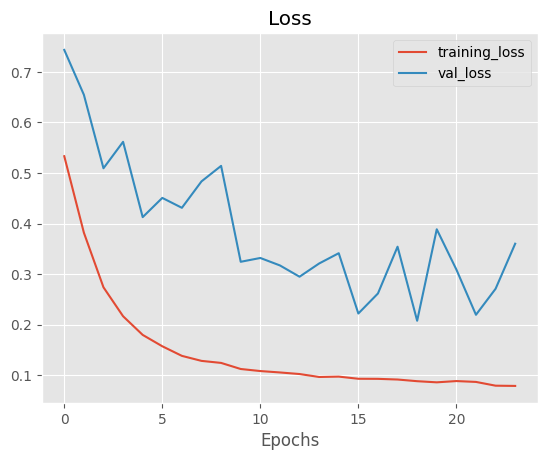

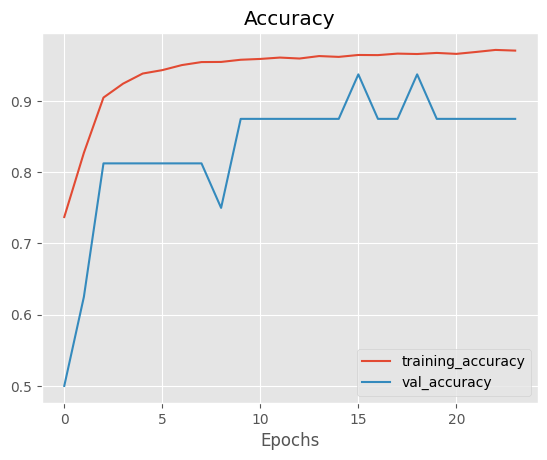

In [16]:
plot_loss_curves(custom_model_history)

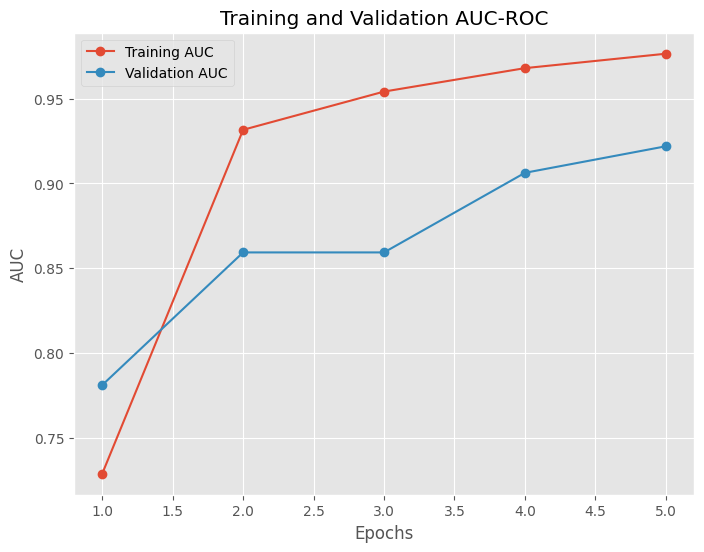

In [ ]:
# Plot the AUC values after training
train_auc = custom_model_history.history["auc"]
val_auc = custom_model_history.history["val_auc"]

epochs = range(0, len(train_auc) - 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_auc, label="Training AUC", marker="o")
plt.plot(epochs, val_auc, label="Validation AUC", marker="o")
plt.title("Training and Validation AUC-ROC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.grid(False)
plt.show()

### tunning for params

In [17]:
def custom_accuracy(y_true, features_and_pred):
    # Extract predictions from features_and_pred
    predictions = features_and_pred[:, -1:]  # Last column is predictions
    return tf.keras.metrics.binary_accuracy(y_true, predictions)

In [18]:
import tensorflow as tf

class OptimizedVariancePenalizedLoss(tf.keras.losses.Loss):
    def __init__(self, variance_weight, feature_sampling_ratio, lambda_, name='optimized_variance_loss'):
        super().__init__(name=name)
        self.variance_weight = variance_weight
        self.feature_sampling_ratio = feature_sampling_ratio
        self.lambda_ = lambda_  # Balancing factor for binary crossentropy loss

    @tf.function
    def call(self, y_true, features_and_pred):
        # Split features and predictions
        features = features_and_pred[:, :-1]  # All features except the last column
        predictions = features_and_pred[:, -1:]  # Last column is predictions

        # Sample features to reduce computation
        feature_dim = tf.shape(features)[1]
        sample_size = tf.cast(tf.cast(feature_dim, tf.float32) * self.feature_sampling_ratio, tf.int32)
        indices = tf.random.shuffle(tf.range(feature_dim))[:sample_size]
        sampled_features = tf.gather(features, indices, axis=1)

        # Calculate variance for sampled features
        mean = tf.reduce_mean(sampled_features, axis=0, keepdims=True)
        variance = tf.reduce_mean(tf.square(sampled_features - mean))

        # Binary crossentropy loss
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, predictions)

        # Combine binary crossentropy and variance penalty
        total_loss = tf.reduce_mean(self.lambda_ * bce_loss) + self.variance_weight * variance
        return total_loss

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate

tf.random.set_seed(42)

# Base CNN model
input_layer = Input(shape=(224, 224, 3))

# Convolutional layers
x = Conv2D(10, 1, activation='relu')(input_layer)
x = Conv2D(10, 1, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(10, 1, activation='relu')(x)
x = Conv2D(10, 1, activation='relu')(x)
x = MaxPool2D()(x)

# Penultimate layer
penultimate_features = Flatten()(x)

# Final Dense layer
predictions = Dense(1, activation='sigmoid')(penultimate_features)

# Concatenate penultimate features and predictions
features_and_pred = Concatenate(axis=-1)([penultimate_features, predictions])

# Define the complete model
custom_model_hyper_opt = Model(inputs=input_layer, outputs=features_and_pred)

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'variance_weight': [0.01, 0.1],
    'feature_sampling_ratio': [0.2, 0.5],
    'lambda_': [0.5, 1.0, 2.0]
}

best_params = None
best_accuracy = 0

for params in ParameterGrid(param_grid):
    # Build and compile the model
    tuning_loss = OptimizedVariancePenalizedLoss(
        variance_weight=params['variance_weight'],
        feature_sampling_ratio=params['feature_sampling_ratio'],
        lambda_=params['lambda_']
    )

    custom_model_hyper_opt.compile(optimizer='adam',
                                   loss=tuning_loss,
                                   metrics=[custom_accuracy])

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    custom_model_hyper_opt.fit(train_data,
                               validation_data=valid_data,
                               epochs=20,
                               batch_size=32,
                               callbacks=[callback,
                                            create_tensorboard_callback("chest_xray", "hyper_params_opt")
                                            ])

    # Evaluate the model
    _, accuracy = custom_model_hyper_opt.evaluate(valid_data, verbose=0)

    # Keep track of the best parameters
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Saving TensorBoard log files to: chest_xray/hyper_params_opt/20250127-103358
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - custom_accuracy: 0.8760 - loss: 0.1871 - val_custom_accuracy: 0.8125 - val_loss: 0.3353
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - custom_accuracy: 0.9601 - loss: 0.0607 - val_custom_accuracy: 0.8750 - val_loss: 0.2242
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - custom_accuracy: 0.9580 - loss: 0.0554 - val_custom_accuracy: 0.8750 - val_loss: 0.2087
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - custom_accuracy: 0.9637 - loss: 0.0486 - val_custom_accuracy: 0.9375 - val_loss: 0.1120
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - custom_accuracy: 0.9619 - loss: 0.0501 - val_custom_accuracy: 0.9375 - val_loss: 0.0752
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - custom_accuracy: 0.9623 - loss: 0.0486 - val_custom_accuracy: 0.9375 - val_loss: 0.1188
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - custom_acc

### variance penalized for custom model - need to use the best params recieved by params tune

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Base CNN model
input_layer = Input(shape=(224, 224, 3))

# Convolutional layers
x = Conv2D(10, 1, activation='relu')(input_layer)
x = Conv2D(10, 1, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(10, 1, activation='relu')(x)
x = Conv2D(10, 1, activation='relu')(x)
x = MaxPool2D()(x)

# Penultimate layer
penultimate_features = Flatten()(x)

# Final Dense layer
predictions = Dense(1, activation='sigmoid')(penultimate_features)

# Concatenate penultimate features and predictions
features_and_pred = Concatenate(axis=-1)([penultimate_features, predictions])

# Define the complete model
custom_model_penalized = Model(inputs=input_layer, outputs=features_and_pred)

# Compile with the custom loss function
custom_loss = OptimizedVariancePenalizedLoss(variance_weight=0.01, feature_sampling_ratio=0.2, lambda_=0.5)
custom_model_penalized.compile(
    loss=custom_loss,
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[custom_accuracy]
)

callback_penalized = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
custom_model_penalized_history = custom_model_penalized.fit(
    train_data,
    epochs=30,
    validation_data=valid_data,
    callbacks=[callback_penalized,
               create_tensorboard_callback("chest_xray", "variance_penalized_model")])

Saving TensorBoard log files to: chest_xray/variance_penalized_model/20250313-053518
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 862ms/step - custom_accuracy: 0.7163 - loss: 0.2865 - val_custom_accuracy: 0.5625 - val_loss: 0.3439
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 852ms/step - custom_accuracy: 0.7939 - loss: 0.2088 - val_custom_accuracy: 0.6250 - val_loss: 0.3269
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 851ms/step - custom_accuracy: 0.8978 - loss: 0.1450 - val_custom_accuracy: 0.8125 - val_loss: 0.2747
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 846ms/step - custom_accuracy: 0.9188 - loss: 0.1158 - val_custom_accuracy: 0.8125 - val_loss: 0.2608
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 862ms/step - custom_accuracy: 0.9356 - loss: 0.0940 - val_custom_accuracy: 0.8125 - val_loss: 0.2676
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 849ms/step - custom_accuracy: 0.9418 - loss: 0.0803 - val_custom_accuracy: 0.8125 - val_loss: 0.2344
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━

In [21]:
def plot_loss_curves_custom(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    accuracy = history.history['custom_accuracy']
    val_accuracy = history.history.get('val_custom_accuracy', [])

    epochs = range(len(loss))
    val_epochs = range(len(val_loss))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    if val_loss:
        plt.plot(val_epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    if val_accuracy:
        plt.plot(val_epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

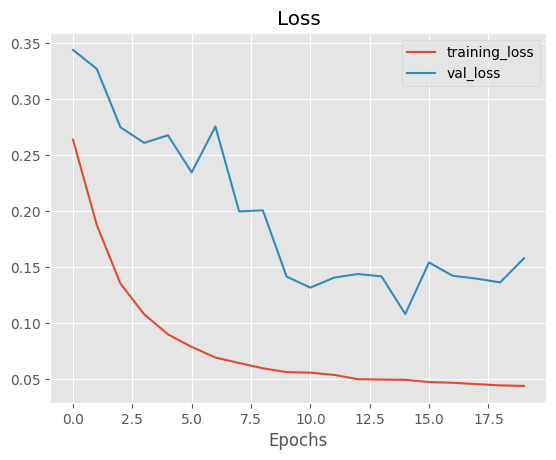

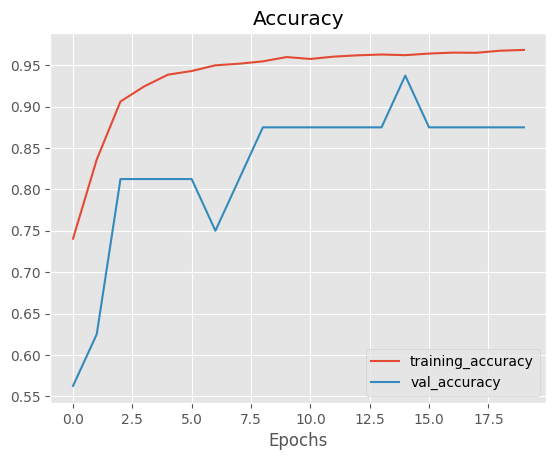

In [22]:
plot_loss_curves_custom(custom_model_penalized_history)

In [23]:
custom_model_penalized.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - custom_accuracy: 0.6596 - loss: 0.4346


[0.2574843466281891, 0.807692289352417]

In [24]:
custom_model_penalized.evaluate(train_data)

163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - custom_accuracy: 0.9590 - loss: 0.0496


[0.05230283364653587, 0.9618481397628784]

In [25]:
custom_model_penalized.evaluate(valid_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - custom_accuracy: 0.9375 - loss: 0.1079


[0.10790251195430756, 0.9375]

## Data Augmented model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Image size for resizing
IMG_SIZE = (224, 224)

# Data augmentation
train_augmentation = tf.keras.Sequential([
    RandomZoom(0.1), # Zoom in/out by 10%
    RandomTranslation(height_factor=0.1, width_factor=0.1)  # Randomly shift images by 10%
])

# Load and augment the training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_path,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42
)
# Apply augmentation to the training data
train_data_augmented = train_data.map(lambda x, y: (train_augmentation(x)/255.0, y))

# Load the validation and test data (no augmentation, only resizing)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=val_path,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=32,
    shuffle=False
)
valid_data = valid_data.map(lambda x, y: (x/255.0, y))

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=32,
    shuffle=False
)
test_data = test_data.map(lambda x, y: (x/255.0, y))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:

augmented_model = Sequential([
    Conv2D(10, 1, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 1, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 1, activation='relu'),
    Conv2D(10, 1, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Recompile the model
augmented_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

# Train the model with augmented data
callback_augmented_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

augmented_model_history = augmented_model.fit(
    train_data_augmented,
    epochs=30,
    validation_data=valid_data,
    callbacks=[callback_augmented_model,
               create_tensorboard_callback("chest_xray", "augmented_model")]
)

Saving TensorBoard log files to: chest_xray/augmented_model/20250128-134654
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7351 - auc: 0.5116 - loss: 0.5848 - val_accuracy: 0.5000 - val_auc: 0.6562 - val_loss: 0.7926
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.7355 - auc: 0.7216 - loss: 0.5436 - val_accuracy: 0.5000 - val_auc: 0.8750 - val_loss: 0.6861
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7524 - auc: 0.8238 - loss: 0.4941 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 0.6023
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7985 - auc: 0.8749 - loss: 0.4337 - val_accuracy: 0.8125 - val_auc: 0.8594 - val_loss: 0.5247
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8361 - auc: 0.8992 - loss: 0.3825 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 0.6278
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8646 - auc: 0.9250 - loss: 0.3332 - val_accuracy: 0.

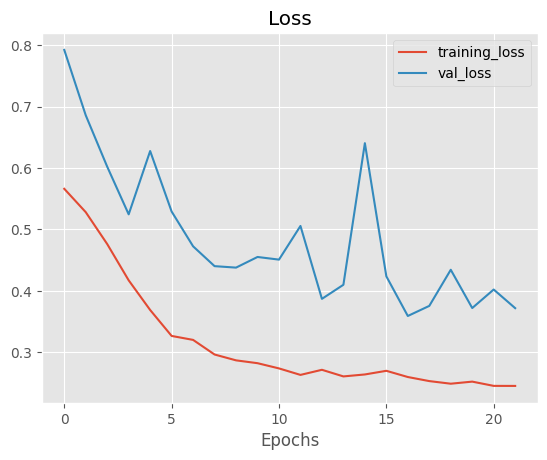

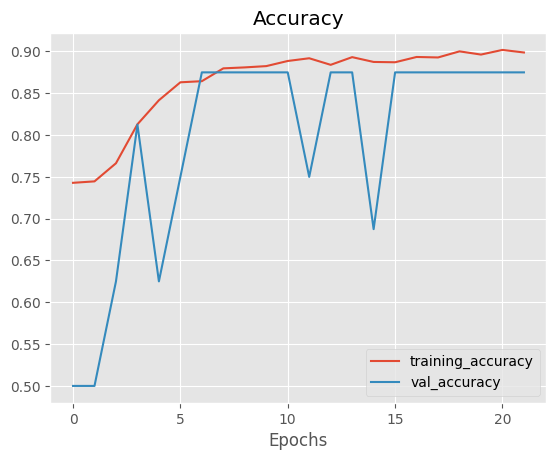

In [ ]:
plot_loss_curves(augmented_model_history)

In [ ]:
augmented_model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.7099 - auc: 0.6133 - loss: 0.5667


[0.4130483865737915, 0.7948718070983887, 0.8929377794265747]

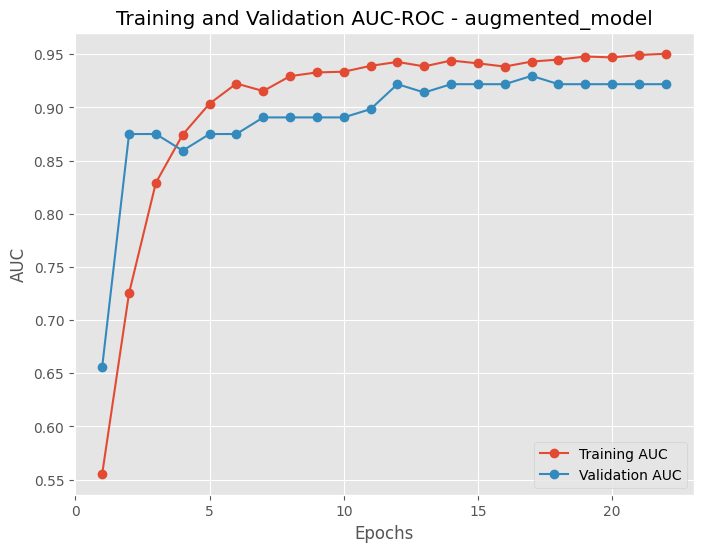

In [ ]:
# Plot the AUC values after training
train_auc = augmented_model_history.history["auc"]
val_auc = augmented_model_history.history["val_auc"]

epochs = range(1, len(train_auc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_auc, label="Training AUC", marker="o")
plt.plot(epochs, val_auc, label="Validation AUC", marker="o")
plt.title("Training and Validation AUC-ROC - augmented_model")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()